In [243]:
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from urllib import request
from bs4 import BeautifulSoup
import ssl
import csv
import string
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import re
import scipy.stats
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [108]:
def getPageBrowser(URL, browser) :
    browser.get(URL)
    pageLength = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
    htmlBS = BeautifulSoup(browser.page_source,"html.parser")
    divs = htmlBS.select('div[class*="scrollerItem"]')
    checkCounter = 0
    noOfDivs = len(divs)
    while(noOfDivs< 1200):
        lastCheckPoint = pageLength
        time.sleep(0.2)
        pageLength = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
        checkCounter+=1
        if checkCounter == 40 :
            htmlBS = BeautifulSoup(browser.page_source,"html.parser")
            divs = htmlBS.select('div[class*="scrollerItem"]')
            oldNoOfDivs = noOfDivs
            noOfDivs = len(divs)
            checkCounter = 0
            if oldNoOfDivs == noOfDivs:
                return browser
    return browser

In [109]:
#Replicating code but this time without the Tag Number, and to write data into csv file
#script May scrape only partial data if internet connection is not stable since it will incorrectly think that the browser
#has finished loading the page and will go to its next task, thus skipping the page


redditsFile = open('Chosen Reddits.txt')
browser = webdriver.Chrome()
dataFile = open('./data/data.csv','w')
fieldnames = ['Text', 'Subreddit','Title']
writer = csv.DictWriter(dataFile, fieldnames=fieldnames)


for line, classNumber in zip(redditsFile, range(5)):
    browser = getPageBrowser(line, browser)
    htmlBS = BeautifulSoup(browser.page_source,"html.parser")
    divs = htmlBS.select('div[class*="scrollerItem"]')
    
    for div in divs:
        try:
            text = div.find('div',{"class":"md"})
            title = div.find('h2')
            
            if text is None :
                text = 'none'
            else : 
                text = text.getText()
            
            if title is None :
                title = 'none'
            else : 
                title = title.getText()
                
            writer.writerow({'Title': title  ,'Text':text, 'Subreddit' : str(classNumber)})
        except Exception as e:
            print(e)
            continue
print('CSV File Writing Complete')
browser.close()

'charmap' codec can't encode character '\u03b2' in position 146: character maps to <undefined>
'charmap' codec can't encode character '\u2082' in position 185: character maps to <undefined>
'charmap' codec can't encode character '\u2010' in position 133: character maps to <undefined>
'charmap' codec can't encode character '\u2010' in position 127: character maps to <undefined>
'charmap' codec can't encode character '\u03b1' in position 276: character maps to <undefined>
'charmap' codec can't encode character '\u202d' in position 2152: character maps to <undefined>
'charmap' codec can't encode character '\u0107' in position 29: character maps to <undefined>
'charmap' codec can't encode character '\u200e' in position 4118: character maps to <undefined>
'charmap' codec can't encode characters in position 262-265: character maps to <undefined>
'charmap' codec can't encode character '\u2032' in position 133: character maps to <undefined>
'charmap' codec can't encode character '\u2015' in po

In [8]:
def clear_punctuation(s):
    string_punctuation = ".#,_;:!*$@&[]()<>\'\""
    clear_string = ""
    for symbol in s:
        if symbol not in string.punctuation and symbol not in string_punctuation:
                clear_string += symbol
    return clear_string

def isGarbage(s):
    garbage = ['the','a','an','of','in','from','to','at','as','by']
    if s in garbage :
        return True
    if re.match('http.*',s):
        return True
    return False


In [9]:
fieldnames = ['Text', 'Subreddit','Title']
data = []
allWords = []

#Collect data from old CSV

with open('./data/data.csv') as input :
    reader = csv.DictReader(input, fieldnames=fieldnames)
    for row in reader : 
        data.append(row)
    print('The total number of samples in the datafile is ' + str(len(data)))

The total number of samples in the datafile is 2801


In [10]:
#get All Words Throughout all samples

for row in data :
    text = row['Title']+ row['Text']
    words = text.split()
    for word in words : 
        word = clear_punctuation(word)
        if len(word)<= 1:
            continue
        if isGarbage(word) :
            continue
        if word in allWords :
            continue
        allWords.append(word.lower())
        
metaDataFile = open('./data/metaData.csv','w')
writer = csv.writer(metaDataFile)
writer.writerow(allWords)
    
print ('The total number of words in our data file is ' + str(len(allWords)))
print ('MetaData is now Written in the MetaData.csv file')

The total number of words in our data file is 22675
MetaData is now Written in the MetaData.csv file


In [11]:
#Rewrite words counts as features in new Data File, and write the target values as well

newDataFile = open('./data/newData.csv','w')
writer = csv.DictWriter(newDataFile, fieldnames=['Subreddit']+allWords)

for row in data : 
    tempDict = dict()
    tempDict['Subreddit'] = row['Subreddit']
    text = row['Title']+row['Text']
    words = text.split()
    for word in words :
        word = clear_punctuation(word)
        if len(word)<= 1:
            continue
        if isGarbage(word) :
            continue
        tempDict[word] = int(tempDict.get(word, 0))+1
    for word in allWords:
        tempDict[word] = tempDict.get(word, 0)
    writer.writerow(tempDict)

print('Finished Writing newData CSV file')

Finished Writing newData CSV file


In [13]:
#read data from csv
data = pd.read_csv('./data/newData.csv', header=None, index_col = False, names=['Subreddit']+allWords)


SyntaxError: invalid syntax (<ipython-input-13-e8aee34840ec>, line 3)

In [91]:
# splitting data into inputs and outputs

X = (data.iloc[:, 1:]).values
y = (data.iloc[:, 0]).values

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state = 0)

In [130]:
#Needs to be tried with a greater memory. I think combining features or words together will have more meaning
#Phrases of 2 words can be good for a start

#poly= PolynomialFeatures(degree = 2).fit(X_train_new)
#X_train_poly = poly.transform(X_train_new)
#X_test_poly = poly.transform(X_test_new)

In [85]:
#Now applying Naive Bayes Multinomial Algorithm
alpha_range = range(1,100,10)
params = dict(alpha = alpha_range)
mnnb = MultinomialNB()
GridSearch = GridSearchCV(mnnb, params, cv=3, scoring='accuracy')
GridSearch.fit(X,y)
print(GridSearch.grid_scores_)

[mean: 0.82078, std: 0.01802, params: {'alpha': 1}, mean: 0.58015, std: 0.02237, params: {'alpha': 11}, mean: 0.54159, std: 0.02268, params: {'alpha': 21}, mean: 0.52588, std: 0.01674, params: {'alpha': 31}, mean: 0.51232, std: 0.01634, params: {'alpha': 41}, mean: 0.50946, std: 0.01517, params: {'alpha': 51}, mean: 0.50875, std: 0.01164, params: {'alpha': 61}, mean: 0.50696, std: 0.01003, params: {'alpha': 71}, mean: 0.50696, std: 0.00978, params: {'alpha': 81}, mean: 0.50625, std: 0.01092, params: {'alpha': 91}]


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


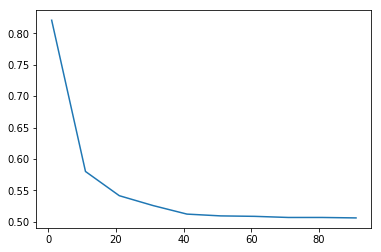

In [119]:
scores = []
for score in GridSearch.grid_scores_:
    scores.append(score[1])
plt.plot(alpha_range, scores)

In [125]:
alpha_range = np.linspace(0.001,0.1,10)
print(alpha_range)
params = dict(alpha = alpha_range)
mnnb = MultinomialNB()
GridSearch = GridSearchCV(mnnb, params, cv=3, scoring='accuracy')
GridSearch.fit(X,y)
print(GridSearch.grid_scores_)

[0.001 0.012 0.023 0.034 0.045 0.056 0.067 0.078 0.089 0.1  ]
[mean: 0.84648, std: 0.00793, params: {'alpha': 0.001}, mean: 0.87255, std: 0.00933, params: {'alpha': 0.012}, mean: 0.87861, std: 0.00953, params: {'alpha': 0.023000000000000003}, mean: 0.87826, std: 0.01193, params: {'alpha': 0.034}, mean: 0.88040, std: 0.01213, params: {'alpha': 0.045000000000000005}, mean: 0.88076, std: 0.01143, params: {'alpha': 0.05600000000000001}, mean: 0.87897, std: 0.01227, params: {'alpha': 0.067}, mean: 0.87861, std: 0.01262, params: {'alpha': 0.07800000000000001}, mean: 0.87790, std: 0.01311, params: {'alpha': 0.08900000000000001}, mean: 0.87754, std: 0.01178, params: {'alpha': 0.1}]


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


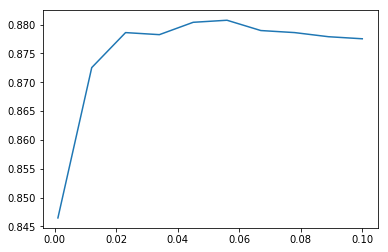

In [126]:
scores = []
for score in GridSearch.grid_scores_:
    scores.append(score[1])
plt.plot(alpha_range, scores)

In [129]:
mnnb = MultinomialNB(alpha=0.045000000000000005, class_prior=None, fit_prior=True)
mnnb.fit(X_train,y_train)
print("Training set score: {:.4f}".format(mnnb.score(X_train, y_train)))
print("Test set score: {:.4f}".format(mnnb.score(X_test, y_test)))

Training set score: 0.9540
Test set score: 0.8841


In [223]:
#Trying TFIDF 

tfidf = TfidfVectorizer(min_df = 1, stop_words = 'english' )
dataIFIDF = []
finalData = []
with open('./data/data.csv') as input :
    reader = csv.DictReader(input, fieldnames=fieldnames)
    for row in reader : 
        dataIFIDF.append(dict(Text = row['Title']+' '+row['Text'], Subreddit = row['Subreddit']))
        
for row in dataIFIDF:
    temp = []
    temp.append(row['Text'])
    temp.append(row['Subreddit'])
    finalData = finalData + [temp]
    

In [232]:
finalData = np.array(finalData)
X_train, X_test, y_train, y_test = train_test_split(finalData[:,0],finalData[:,1], stratify=finalData[:,1], random_state= 0,train_size=0.8,test_size=0.2)

tfidf.fit(X_train,y_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(X_test_tfidf.shape)

(561, 14367)


In [153]:
print(tfidf.vocabulary_)

{'republican': 10945, 'party': 9596, 'declares': 3914, 'war': 13940, 'omarosa': 9295, 'florida': 5563, 'state': 12243, 'house': 6590, 'candidate': 2593, 'admitted': 1112, 'posed': 10033, 'fake': 5283, 'diploma': 4237, 'college': 3105, 'called': 2558, 'meet': 8372, 'press': 10165, 'plays': 9928, 'tape': 12737, 'john': 7357, 'kelly': 7477, 'firing': 5492, 'variety': 13717, 'create': 3630, 'workout': 14200, 'routine': 11240, 'websites': 14021, 'visit': 13842, 'trying': 13325, 'shape': 11660, 'tracks': 13159, 'season': 11498, 'lose': 8002, '10': 24, 'pounds': 10073, 'fat': 5333, 'gain': 5825, 'muscle': 8807, 'hour': 6588, 'day': 3857, 'supreme': 12576, 'court': 3582, 'shaped': 11661, 'trump': 13310, 'restrict': 11020, 'access': 989, 'abortion': 943, 'image': 6773, 'real': 10648, 'test': 12869, 'compassion': 3212, 'say': 11387, 'abstract': 958, 'discussions': 4304, 'conduct': 3307, 'daily': 3801, 'life': 7843, 'dalai': 3804, 'lama': 7637, 'rep': 10895, 'cathy': 2700, 'mcmorris': 8318, 'rodg

In [169]:
testScores = []
trainingScores = []
alphas = np.linspace(0.01,0.1,20)
for alpha in alphas:
    mnnb = MultinomialNB(alpha = alpha)
    mnnb.fit(X_train_tfidf,y_train)
    print("Training set score for alpha {:.4f}: {:.4f}".format(alpha,mnnb.score(X_train_tfidf, y_train)))
    print("Test set score for alpha {:.4f}: {:.4f}".format(alpha,mnnb.score(X_test_tfidf, y_test)))
    testScores.append(mnnb.score(X_test_tfidf, y_test))
    trainingScores.append(mnnb.score(X_train_tfidf, y_train))
    
#best Alpha is 0.0195

Training set score for alpha 0.0100: 0.9536
Test set score for alpha 0.0100: 0.8717
Training set score for alpha 0.0147: 0.9536
Test set score for alpha 0.0147: 0.8841
Training set score for alpha 0.0195: 0.9536
Test set score for alpha 0.0195: 0.8930
Training set score for alpha 0.0242: 0.9536
Test set score for alpha 0.0242: 0.8877
Training set score for alpha 0.0289: 0.9531
Test set score for alpha 0.0289: 0.8877
Training set score for alpha 0.0337: 0.9531
Test set score for alpha 0.0337: 0.8895
Training set score for alpha 0.0384: 0.9531
Test set score for alpha 0.0384: 0.8895
Training set score for alpha 0.0432: 0.9531
Test set score for alpha 0.0432: 0.8877
Training set score for alpha 0.0479: 0.9531
Test set score for alpha 0.0479: 0.8877
Training set score for alpha 0.0526: 0.9531
Test set score for alpha 0.0526: 0.8859
Training set score for alpha 0.0574: 0.9531
Test set score for alpha 0.0574: 0.8841
Training set score for alpha 0.0621: 0.9531
Test set score for alpha 0.0621:

Text(0.5,0,'TrainingScore')

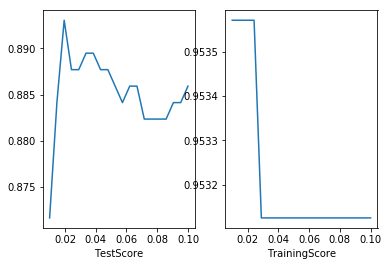

In [171]:
fig, axes = plt.subplots(1,2)
axes[0].plot(alphas,testScores)
axes[0].set_xlabel('Alpha')
axes[0].set_xlabel('TestScore')
axes[1].plot(alphas,trainingScores)
axes[1].set_xlabel('Alpha')
axes[1].set_xlabel('TrainingScore')


#Anything below 0.02 is great for test results, they plateau at 0.8859

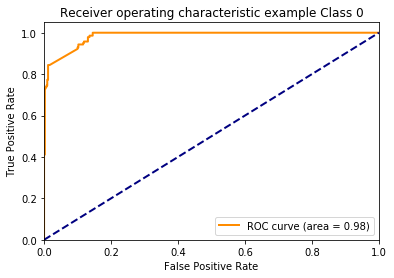

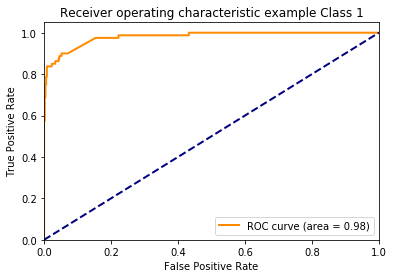

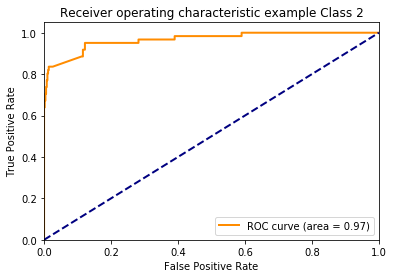

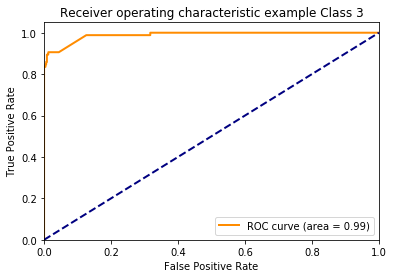

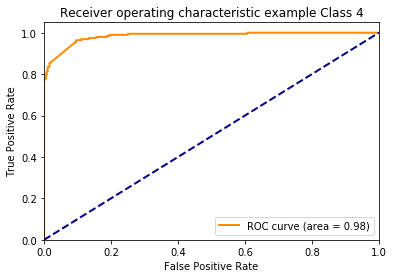

In [245]:
# ROC curve
y_train_bin = label_binarize(y_train, classes=['0', '1', '2', '3', '4'])
n_classes = y_train_bin.shape[1]
y_test_bin = label_binarize(y_test, classes=['0', '1', '2', '3', '4'])

classifier = OneVsRestClassifier(MultinomialNB(alpha=0.1))
y_score = classifier.fit(X_train_tfidf, y_train_bin).predict_proba(X_test_tfidf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    #print(fpr[i])



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example Class '+ str(i))
    plt.legend(loc="lower right")
    plt.show()

In [246]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))



Average precision score, micro-averaged over all classes: 0.95


Training set score for C 100.0000: 0.9545
Test set score for C 100.0000: 0.9020
Training set score for C 621.0526: 0.9545
Test set score for C 621.0526: 0.8984
Training set score for C 1142.1053: 0.9545
Test set score for C 1142.1053: 0.8984
Training set score for C 1663.1579: 0.9545
Test set score for C 1663.1579: 0.9002
Training set score for C 2184.2105: 0.9545
Test set score for C 2184.2105: 0.8984
Training set score for C 2705.2632: 0.9545
Test set score for C 2705.2632: 0.8984
Training set score for C 3226.3158: 0.9545
Test set score for C 3226.3158: 0.8984
Training set score for C 3747.3684: 0.9545
Test set score for C 3747.3684: 0.8984
Training set score for C 4268.4211: 0.9545
Test set score for C 4268.4211: 0.8984
Training set score for C 4789.4737: 0.9545
Test set score for C 4789.4737: 0.8984
Training set score for C 5310.5263: 0.9545
Test set score for C 5310.5263: 0.8966
Training set score for C 5831.5789: 0.9545
Test set score for C 5831.5789: 0.8966
Training set score f

Text(0.5,0,'TrainingScore')

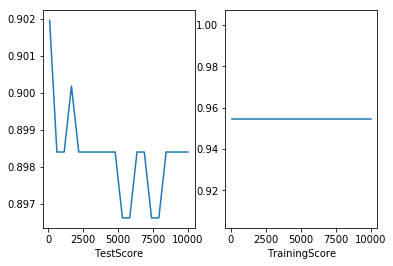

In [188]:
testScores = []
trainingScores = []
cs = np.linspace(100,10000,20)
for c in cs:
    logreg = LogisticRegression(C = c)
    logreg.fit(X_train_tfidf,y_train)
    print("Training set score for C {:.4f}: {:.4f}".format(c,logreg.score(X_train_tfidf, y_train)))
    print("Test set score for C {:.4f}: {:.4f}".format(c,logreg.score(X_test_tfidf, y_test)))
    testScores.append(logreg.score(X_test_tfidf, y_test))
    trainingScores.append(logreg.score(X_train_tfidf, y_train))
fig, axes = plt.subplots(1,2)
axes[0].plot(cs,testScores)
axes[0].set_xlabel('C')
axes[0].set_xlabel('TestScore')
axes[1].plot(cs,trainingScores)
axes[1].set_xlabel('C')
axes[1].set_xlabel('TrainingScore')

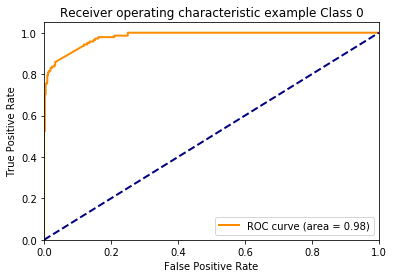

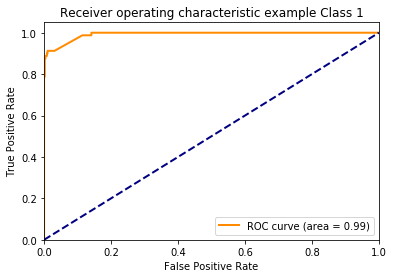

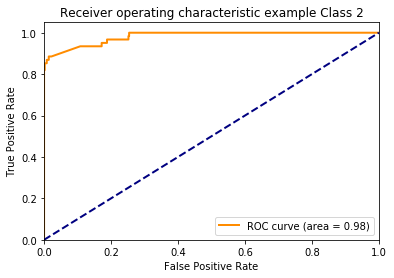

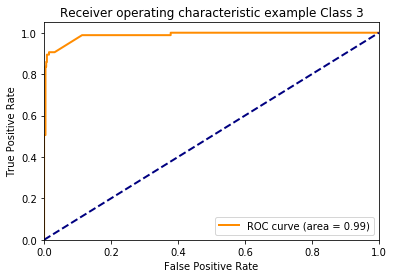

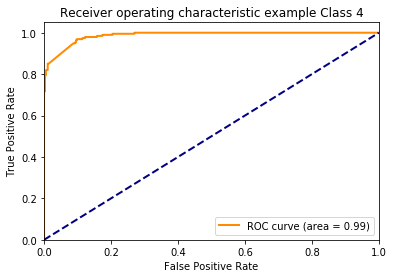

In [248]:
# ROC curve
y_train_bin = label_binarize(y_train, classes=['0', '1', '2', '3', '4'])
n_classes = y_train_bin.shape[1]
y_test_bin = label_binarize(y_test, classes=['0', '1', '2', '3', '4'])

classifier = OneVsRestClassifier(LogisticRegression(C = 100))
y_score = classifier.fit(X_train_tfidf, y_train_bin).predict_proba(X_test_tfidf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    #print(fpr[i])



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example Class '+ str(i))
    plt.legend(loc="lower right")
    plt.show()

In [249]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))



Average precision score, micro-averaged over all classes: 0.96


Training set score for n_neighbors 250.0000: 0.7594
Test set score for n_neighbors 250.0000: 0.7487
Training set score for n_neighbors 300.0000: 0.6960
Test set score for n_neighbors 300.0000: 0.6881
Training set score for n_neighbors 350.0000: 0.6491
Test set score for n_neighbors 350.0000: 0.6381
Training set score for n_neighbors 400.0000: 0.6308
Test set score for n_neighbors 400.0000: 0.6007
Training set score for n_neighbors 450.0000: 0.6353
Test set score for n_neighbors 450.0000: 0.6025
Training set score for n_neighbors 500.0000: 0.6388
Test set score for n_neighbors 500.0000: 0.6114
Training set score for n_neighbors 600.0000: 0.6951
Test set score for n_neighbors 600.0000: 0.6774
Training set score for n_neighbors 1000.0000: 0.6978
Test set score for n_neighbors 1000.0000: 0.6863
Training set score for n_neighbors 1500.0000: 0.3567
Test set score for n_neighbors 1500.0000: 0.3565


Text(0.5,0,'TrainingScore')

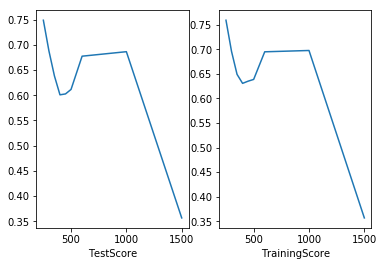

In [190]:
testScores = []
trainingScores = []
kns = [250,300,350,400,450,500,600,1000,1500]
for kn in kns:
    knn = KNeighborsClassifier(n_neighbors = kn)
    knn.fit(X_train_tfidf,y_train)
    print("Training set score for n_neighbors {:.4f}: {:.4f}".format(kn,knn.score(X_train_tfidf, y_train)))
    print("Test set score for n_neighbors {:.4f}: {:.4f}".format(kn,knn.score(X_test_tfidf, y_test)))
    testScores.append(knn.score(X_test_tfidf, y_test))
    trainingScores.append(knn.score(X_train_tfidf, y_train))

fig, axes = plt.subplots(1,2)
axes[0].plot(kns,testScores)
axes[0].set_xlabel('kn')
axes[0].set_xlabel('TestScore')
axes[1].plot(kns,trainingScores)
axes[1].set_xlabel('kn')
axes[1].set_xlabel('TrainingScore')

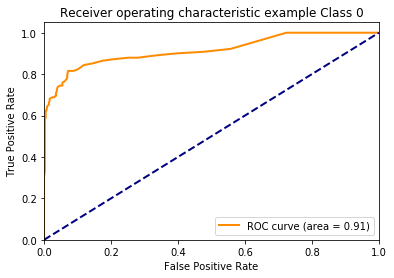

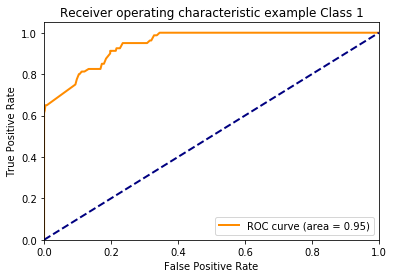

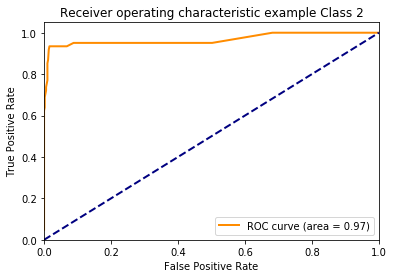

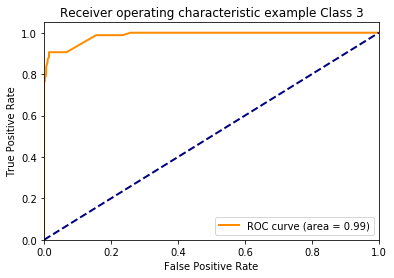

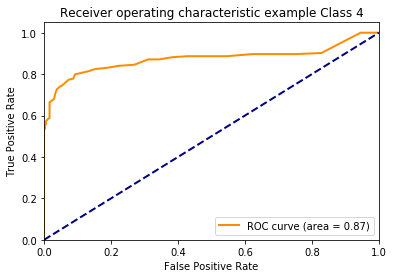

In [250]:
# ROC curve
y_train_bin = label_binarize(y_train, classes=['0', '1', '2', '3', '4'])
n_classes = y_train_bin.shape[1]
y_test_bin = label_binarize(y_test, classes=['0', '1', '2', '3', '4'])

classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 250))
y_score = classifier.fit(X_train_tfidf, y_train_bin).predict_proba(X_test_tfidf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    #print(fpr[i])



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example Class '+ str(i))
    plt.legend(loc="lower right")
    plt.show()

In [251]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))



Average precision score, micro-averaged over all classes: 0.85
